# Predicting heart rate during excercise with LSTM

Training an LSTM model to predict heart rate in n seconds in future based on the sensor measurements over the past 60 seconds. The data is collected from Garmin Fenix 6s during running excercises, performed by the author, mostly in a hilly environment. The fit files data was converted into csv files with fitdecode library https://github.com/polyvertex/fitdecode. Fit-files format is used at least by Garmin and Suunto devices.

Some of the useful inputs available for cycling or running include:
- heart rate
- cadence
- speed
- altitude
- grade 
- power
- distance

In [37]:
# load libraries
import os, glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# location of the fit files
fit_path = "/home/riku/projects/athlet_hr_predict/fit_file_csv"
fit_test_path = "/home/riku/projects/athlet_hr_predict/fit_file_test_csv"
graph_path = "/home/riku/projects/athlet_hr_predict/graphs"
os.chdir(fit_path)


In [38]:
# add calculated altitude difference column, and 5sec moving average column. Remove geographical coordinates for privacy.
fit_files = glob.glob("*.csv")
for file in fit_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')
    df['alt_difference'] = df['enhanced_altitude'] - df['enhanced_altitude'].shift(1)
    df['rolling_ave_alt'] = df['alt_difference'].rolling(window=5).mean()
    df = df.bfill()
    df = df.drop(['position_lat','position_long'], axis=1, errors='ignore')
    df.to_csv(fit_path+'/'+file)


In [39]:
# set parameters, file names

#select the features for EDA graphs:
eda_model_features =  ["heart_rate", "enhanced_speed","rolling_ave_alt", "cadence", "distance", "enhanced_altitude"] #  cadence, enhanced_altitude, distance, heart_rate, enhanced_speed, rolling_ave_alt

#select the predictors for the model:
model_features =  ["heart_rate", "enhanced_speed","rolling_ave_alt","cadence"] #  cadence, altitude, distance, heart_rate, enhanced_speed, rolling_ave_alt
batch_size = 500 # training batch size for the LSTM
epochs = 100 # maximum number of epochs - autostop will work on per file basis
learning_rate = 0.002
n_X = 60 # number of timesteps for training
n_y = 5 # number of timesteps in future for prediction
step = 1 # step size of predictors for model training

sequence_length = int(n_X/step)
n_fit_files_test_set = 10 # number of files for validation dataset (only 1 validation file supported at the moment)

# select the training files and the validation files 
train_files = glob.glob(fit_path+"/*.csv")[0:-n_fit_files_test_set]
valid_files = glob.glob(fit_path+"/*.csv")[-n_fit_files_test_set:]
test_files = glob.glob(fit_test_path+"/*.csv")


In [40]:
# calculate the data normalisation parameters from all training data

def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    #return (data - data_mean) / data_std, data_mean, data_std
    return data_mean, data_std

li = []

for file in train_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df_mean, df_std = normalize(df)

def denormalize_hr(data):
    return data*df_std[0]+df_mean[0] 

## Short EDA

Selected features are shown on the plots. The fit file here was collected during a hilly 5km run. It shows large variability during the workout in heart rate, speed and altitude. Cadence is relatively constant throughout the excercise.

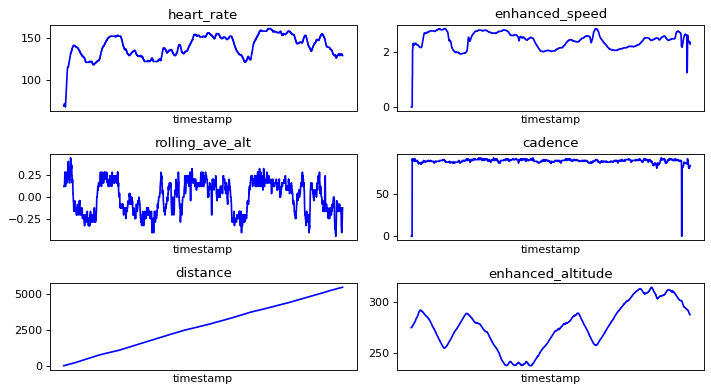

In [ ]:
eda_example = pd.read_csv(fit_path+'/RUN_2021-08-26-07-15-23.fit.csv', index_col='timestamp')[eda_model_features]

def show_raw_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=int(len(eda_model_features)/2+0.5), ncols=2, figsize=(9, 5), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(eda_model_features)):
        key = eda_model_features[i]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color='b',
            title="{}".format(key),
            rot=25,
        )
        ax.set_xticks([])
    plt.tight_layout()

show_raw_visualization(eda_example)
plt.savefig(graph_path+"/HR_eda_t"+str(n_y)+".png")


## Create validation dataset

In [42]:
# validation dataset - train each file at the time
n=0
for file in valid_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]]
    
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )
    if n==0 : dataset_val_old = dataset_val
    if n>0 : dataset_val_old = dataset_val.concatenate(dataset_val_old)
    
    n=n+1

dataset_val = dataset_val_old

## Build the model

In [43]:
# get the shapes of X & y for a batch
for batch in dataset_val.take(1):
    inputs, targets = batch

# the model
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
#lstm_out = keras.layers.LSTM(4, return_sequences=True)(inputs)
lstm_out = keras.layers.LSTM(4)(inputs)
outputs = keras.layers.Dropout(0.5)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=["mae", "acc"], loss="mae")
model.summary()

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=1)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 60, 4)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


## Load the training data, train the model file by file

Each file is processed separately, and training epochs repeated as long as the model improves for each model up to the variable $epochs$ defined earlier. 

In [44]:
# training dataset

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

n=0
for file in train_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    print(file)
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]].values
    
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size
    )
    
    if n==0 : dataset_train_old = dataset_train
    if n>0 : dataset_train_old = dataset_train.concatenate(dataset_train_old)

    n=n+1

dataset_train=dataset_train_old


/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-08-10-12-54-01.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-07-21-09-57-29.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-05-09-10-51-15.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-06-24-10-46-01.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-07-01-10-38-15.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-08-26-07-15-23.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-05-12-08-15-45.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-05-02-08-59-37.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-04-06-09-04-28.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-04-28-12-34-28.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-04-21-10-03-47.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_csv/RUN_2021-06-16-08-58-21.fit.csv
/hom

In [45]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
    verbose=0
)



Epoch 00001: val_loss improved from inf to 0.32016, saving model to model_checkpoint.h5

Epoch 00002: val_loss improved from 0.32016 to 0.20256, saving model to model_checkpoint.h5

Epoch 00003: val_loss improved from 0.20256 to 0.15058, saving model to model_checkpoint.h5

Epoch 00004: val_loss improved from 0.15058 to 0.12918, saving model to model_checkpoint.h5

Epoch 00005: val_loss improved from 0.12918 to 0.11733, saving model to model_checkpoint.h5

Epoch 00006: val_loss improved from 0.11733 to 0.10690, saving model to model_checkpoint.h5

Epoch 00007: val_loss improved from 0.10690 to 0.09917, saving model to model_checkpoint.h5

Epoch 00008: val_loss improved from 0.09917 to 0.09501, saving model to model_checkpoint.h5

Epoch 00009: val_loss improved from 0.09501 to 0.09222, saving model to model_checkpoint.h5

Epoch 00010: val_loss improved from 0.09222 to 0.08985, saving model to model_checkpoint.h5

Epoch 00011: val_loss improved from 0.08985 to 0.08819, saving model to m

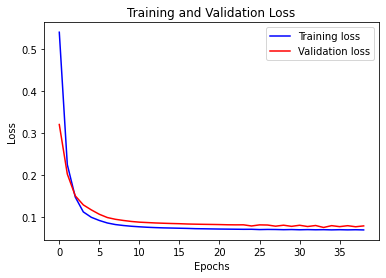

<Figure size 432x288 with 0 Axes>

In [46]:
visualize_loss(history, "Training and Validation Loss")
plt.savefig(graph_path+'/HR_his_t'+str(n_y)+".png")


## Check the model predictions visually

In [47]:
n=0
for file in test_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    print(file)
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]].values
    
    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=10
    )
    
    if n>0:
        dataset_test_old = dataset_train_old.concatenate(dataset_test)
    
    dataset_test_old = dataset_test
    
    n=n+1
dataset_test = dataset_test_old

/home/riku/projects/athlet_hr_predict/fit_file_test_csv/RUN_2021-09-01-09-09-44.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_test_csv/RUN_2021-08-29-09-28-52.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_test_csv/RUN_2021-08-31-10-10-56.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_test_csv/RUN_2021-08-28-10-18-42.fit.csv
/home/riku/projects/athlet_hr_predict/fit_file_test_csv/RUN_2021-08-05-11-12-41.fit.csv


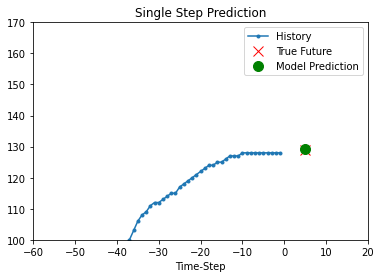

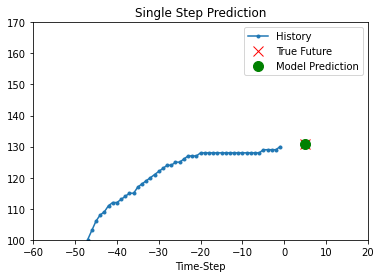

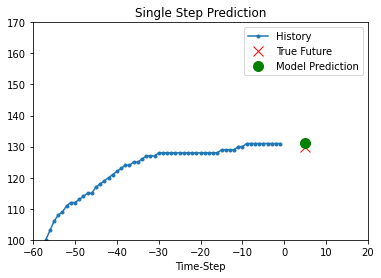

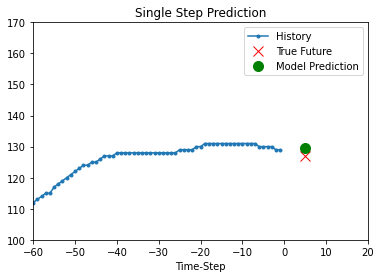

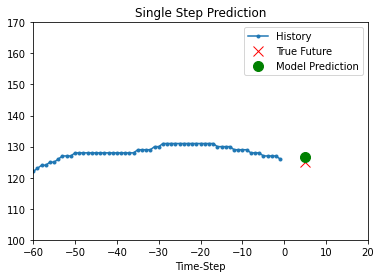

In [48]:


def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))

    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.ylim(100,170)
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_test.take(5):
    show_plot(
        [denormalize_hr(x[0][:, 0].numpy()), denormalize_hr(y[0]), denormalize_hr( model.predict(x)[0])],
        n_y,
        "Single Step Prediction",
    )

## Model evaluation 

under construction

In [49]:
# create a testing dataset from the kept-aside files
n=0
for file in test_files:
    df = pd.read_csv(file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]].values
    
    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=1
    )
    
    if n==0 : dataset_test_old = dataset_test
    if n>0 : dataset_test_old = dataset_test_old.concatenate(dataset_test)
    
    n=n+1
dataset_test = dataset_test_old

# make a dataframe with predictions and observations
d=pd.DataFrame([0,1])
for x, y in dataset_test:
    a = denormalize_hr(y[0]).numpy(), denormalize_hr( model.predict(x)[0])
    c = pd.DataFrame(a).T
    d = d.merge(c, how='outer')
d.columns=['measured', 'predicted']
d = d.bfill()

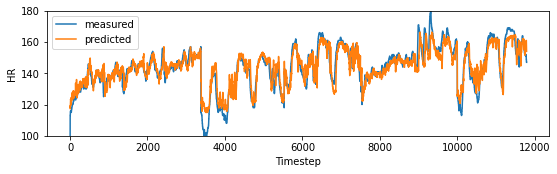

In [ ]:
# time domain plot with observed blue, and predicted orange. Predicted is calculated values where previous 30sec of inputs are missing.
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(9, 2.3)
d.plot(ylim=(100,180), xlabel='Timestep', ylabel='HR', ax=ax1)
plt.savefig(graph_path+'/HR_ex_t'+str(n_y)+".png")

In [ ]:
# calculate some stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import scipy

y_test, pred_test = d['measured'].values,d['predicted'].values

MSE_test=round(mean_squared_error(y_test, pred_test, squared=True),3)
MAE_test=round(mean_absolute_error(y_test, pred_test),3)

test_sdev = np.std(pred_test-y_test)*1.96
test_mean = np.mean(pred_test-y_test)


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

mean_s, ci95_l, ci95_h, mean_uncertainty = mean_confidence_interval(data=(pred_test-y_test))


print('Test dataset\nMAE = '+ str(MAE_test)+", MSE = "+str(MSE_test))
print ('Mean and 95% prediction interval = {} +/- {}'.format(test_mean,test_sdev))
print('Uncertainty of mean = '+ str(mean_uncertainty))


Test dataset
MAE = 4.285, MSE = 36.764
Mean and 95% prediction interval = 0.06199294810986701 +/- 11.883487375496287
Uncertainty of mean = 0.10945662066946904


/home/riku/miniconda3/envs/hrpredict/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


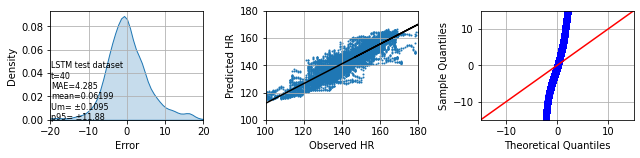

<Figure size 432x288 with 0 Axes>

In [ ]:
# graph the model performance

import seaborn as sns
import statsmodels.api as sm

m, b = np.polyfit(y_test, pred_test, 1)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
fig.set_size_inches(9, 2.3)
sns.kdeplot( x=pred_test-y_test, fill=True, ax=ax1, common_norm=False)
ax2.scatter(x=y_test, y=pred_test, s=1)
ax2.plot(y_test, m*y_test + b, c='black')
sm.qqplot((pred_test-y_test), line ='45', ax=ax3)

ax1.set_xlim(-20,20)
ax1.set_xlabel('Error')
ax2.set_xlabel('Observed HR')
ax2.set_ylabel('Predicted HR')
ax2.set_xlim(100,180)
ax2.set_ylim(100,180)
ax3.set_xlim(-15,15)
ax3.set_ylim(-15,15)
ax1.text(-19.8,0.0,'LSTM test dataset\nt='+ str(n_y) + '\nMAE='+str(MAE_test) + "\nmean="+ str(round(mean_s,5)) + "\nUm= ±"+ str(round(mean_uncertainty,4))+'\np95= ±'+ str(round(test_sdev,2)) , fontsize=8 )
ax1.grid()
ax2.grid()
ax3.grid()
plt.tight_layout()
plt.show()
plt.savefig(graph_path+'/HR_t'+str(n_y)+".png")


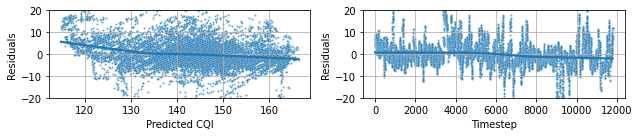

<Figure size 432x288 with 0 Axes>

In [ ]:
# further residuals plots
import random
fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(9, 2)

y_pred_error = (pred_test - y_test)
x_n = np.arange(0,len(y_pred_error))

sns.regplot(x=pred_test, y=y_pred_error, scatter=False,  ax=ax1, ci=95, lowess=True)
sns.regplot(x=x_n, y=y_pred_error, scatter=False,  ax=ax2, ci=95, lowess=True)
sns.scatterplot(x=pred_test, y=y_pred_error,  ax=ax1, alpha = 0.7, s=4)
sns.scatterplot(x=x_n, y=y_pred_error,  ax=ax2, alpha = 0.7, s=4)

ax2.set_ylim(-20,20)
ax1.set_ylim(-20,20)
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Residuals')
ax1.set_xlabel('Predicted CQI')
ax1.set_ylabel('Residuals')
ax1.grid()
ax2.grid()
plt.tight_layout()
plt.show()
plt.savefig(graph_path+'/HR_res_t'+str(n_y)+".png")